# Deep learning
---------------------------

This example shows how we can use ATOM to train and validate a Convolutional Neural Network implemented using [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym='NN', fullname='Neural network')
model.type = 'gradient'

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ================== >>
Shape: (7000, 2)
Categorical columns: 1
Scaled: False
-----------------------------------
Train set size: 6000
Test set size: 1000
-----------------------------------
Train set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.1:1.1:1.1:1.1:1.1:1.0:1.0:1.2:1.1:1.1
Test set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.2:1.4:1.3:1.0:1.2:1.1:1.3:1.2:1.1:1.2
-----------------------------------
Distribution of classes:
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |       724 |     622 |    102 |
|  1 |       744 |     631 |    113 |
|  2 |       693 |     589 |    104 |
|  3 |       679 |     596 |     83 |
|  4 |       727 |     626 |    101 |
|  5 |       639 |     549 |     90 |
|  6 |       666 |     558 |    108 |
|  7 |       737 |     635 |    102 |
|  8 |       676 |     581 |     95 |
|  9 |       715 |     6

In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")

                                            Features  target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       5
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       7
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       9
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       7
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       0

Every row in the column contains the data of one image, with shape: (28, 28, 1)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 256}
Evaluation --> f1_weighted: 0.9424  Best f1_weighted: 0.9424
Time iteration: 8.314s   Total time: 8.319s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9408  Best f1_weighted: 0.9424
Time iteration: 8.914s   Total time: 17.236s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9532  Best f1_weighted: 0.9532
Time iteration: 12.240s   Total time: 29.479s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 1, 'batch_size': 32}
Evaluation --> f1_weighted: 0.9426  Best f1_weighted: 0.9532
Time iteration: 6.368s   Total time: 35.851s
Initial point 5 ---------------------------------
Parameters --> {'ep

## Analyze the results

In [8]:
# We can use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[7.6079150e-11, 1.3647737e-07, 3.3564876e-10, ..., 2.2290888e-11,
        2.7873742e-07, 2.2211642e-08],
       [9.9997699e-01, 5.7249155e-10, 4.5124486e-07, ..., 5.8728578e-12,
        1.9990871e-06, 1.8863806e-05],
       [2.0215736e-09, 2.4031244e-09, 3.5945394e-07, ..., 1.4841052e-04,
        9.9761610e-07, 1.1678913e-05],
       ...,
       [1.4464187e-10, 9.3491263e-13, 2.4912352e-17, ..., 2.2498216e-15,
        1.5265277e-07, 3.8232368e-08],
       [9.6342032e-04, 4.7254954e-08, 5.2585257e-08, ..., 6.4444627e-09,
        1.6198820e-07, 2.5358229e-09],
       [1.2641001e-05, 1.1896596e-08, 5.5952628e-06, ..., 1.6134092e-05,
        9.9867672e-01, 7.8434474e-04]], dtype=float32)

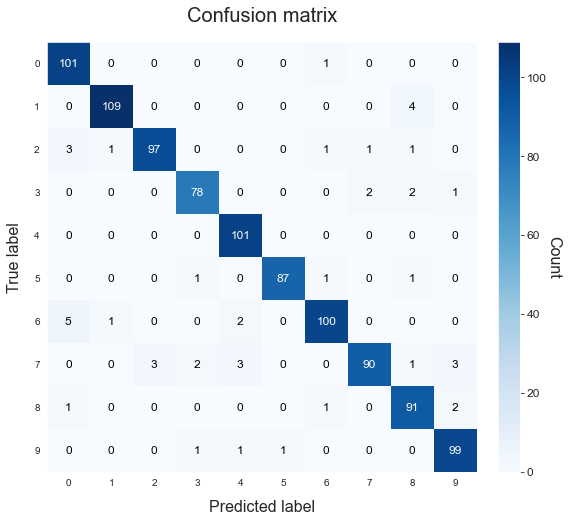

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()